In [38]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns
import numpy as np
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [39]:
def datasetLoader(data_dir, batch_size):
    transform = transforms.Compose([transforms.Resize((256, 256)),
                                    transforms.ToTensor()])

    train_dir = os.path.join(data_dir, "Train")
    test_dir = os.path.join(data_dir, "Test")
    val_dir = os.path.join(data_dir, "Validation")

    train_data = ImageFolder(root=train_dir, transform=transform)
    test_data = ImageFolder(root=test_dir, transform=transform)
    val_data = ImageFolder(root=val_dir, transform=transform)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, val_loader

In [43]:
data_dir = "Dataset"
train_loader, test_loader, val_loader = datasetLoader(data_dir, batch_size=12)
device = torch.device("cuda:0")
num_classes = len(train_loader.dataset.classes)
print(torch.cuda.is_available())

False


In [41]:
print(f"Número de amostras de treinamento: {len(train_loader.dataset)}")
print(f"Número de amostras de teste: {len(test_loader.dataset)}")
print(f"Número de amostras de validação: {len(val_loader.dataset)}")
print("Classes no conjunto de treinamento:")
print(train_loader.dataset.classes)

Número de amostras de treinamento: 459
Número de amostras de teste: 50
Número de amostras de validação: 55
Classes no conjunto de treinamento:
['adidas', 'nike']


In [42]:
resnet = torchvision.models.resnet50(weights = True)
resnet.fc = nn.Linear(2048, num_classes)
resnet = resnet.to(device)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
def confusion_matrix(model, loader):
    model.eval()
    confusion_matrix = np.zeros((2,2))
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs, 1)
            for i in range(labels.size(0)):
                confusion_matrix[labels[i].item()][predicted[i].item()] += 1
    ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Adidas', 'Nike'], yticklabels=['Adidas', 'Nike'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Label')
    return ax

In [ ]:
def accuracy(model, loader):
    model.eval()
    corrected = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrected += (predicted == labels).sum().item()
    return corrected * 100 // total

In [ ]:
def validation(model, loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs,labels)
            val_loss +=loss
    return val_loss/len(loader)

In [ ]:
def train(model, trainloader, testloader, optimizer, criterion, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for data in tqdm(trainloader):
            images, labels = data
            model.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        val_loss = validation(model, testloader, criterion)
        print(f'Epoch: {epoch+1} | Loss: {running_loss/len(trainloader)} | Val Loss: {val_loss}')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)
epochs = 10

In [ ]:
train(resnet, train_loader, test_loader, optimizer, criterion, epochs)

  0%|          | 0/39 [00:00<?, ?it/s]

  8%|▊         | 3/39 [00:27<05:30,  9.18s/it]


KeyboardInterrupt: 

A rede atinge: 80% de acurácia


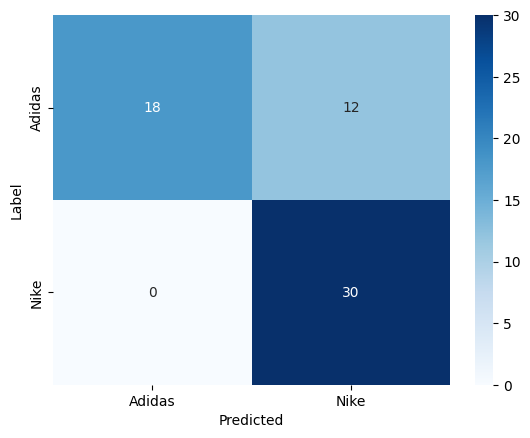

In [ ]:
print(f'A rede atinge: {accuracy(resnet, test_loader)}% de acurácia')
conf_mat = confusion_matrix(resnet, test_loader)